In [1]:
import numpy as np
import nengo
from nengo import Lowpass
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from model import DotPerception, detect_extrema_dot_motion
import pyreadr
import rdata
import json
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

# Model

In [2]:
def build_network(inputs, w_accumulator, w_speed, nActions=2, nNeurons=500, synapse=0.1, seed=0, ramp=1, threshold=0.5, speed=-0.1, relative=0,
        max_rates=nengo.dists.Uniform(60, 80), rA=1, save_w=False, weights_or_decoders="decoders"):
    
    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03
    net.config[nengo.Ensemble].max_rates = max_rates

    # references
    net.inputs = inputs
    net.seed = seed
    net.synapse = synapse
    net.nNeurons = nNeurons

    net.ramp = ramp
    net.threshold = threshold
    net.speed = speed
    net.relative = relative

    func_input = lambda t: net.inputs.sample(t)
    func_threshold = lambda t: net.threshold
    func_speed = lambda t: net.speed
    func_ramp = lambda x: net.synapse * net.ramp * x
    func_value = lambda x: [x[0]-x[1]*net.relative, x[1]-x[0]*net.relative]  # raw evidence vs relative advantage

    ePos = nengo.dists.Choice([[1]])
    iPos = nengo.dists.Uniform(0, 1)

    with net:
        # Inputs
        environment = nengo.Node(func_input)
        baseline_threshold = nengo.Node(func_threshold)
        speed_control = nengo.Node(func_speed)
        # Ensembles
        perception = nengo.Ensemble(nNeurons, nActions, seed=seed)
        accumulator = nengo.Ensemble(nNeurons, nActions, radius=rA, seed=seed)
        value = nengo.Ensemble(nNeurons, nActions, radius=net.threshold, seed=seed)
        boundary = nengo.Ensemble(nNeurons, 1, seed=seed)
        gate = nengo.Ensemble(nNeurons, 1, encoders=ePos, intercepts=iPos, seed=seed)
        action = nengo.networks.EnsembleArray(nNeurons, nActions, encoders=ePos, intercepts=iPos, seed=seed)
        # Connections
        nengo.Connection(environment, perception, seed=seed)  # external inputs
        nengo.Connection(perception, accumulator, synapse=net.synapse, function=func_ramp, seed=seed)  # send percepts to accumulator
        # recurrent cortical connection for accumulation
        if save_w:
            conn_accumulator = nengo.Connection(accumulator, accumulator, synapse=net.synapse, seed=seed)            
        elif weights_or_decoders=="decoders":
            conn_accumulator = nengo.Connection(accumulator.neurons, accumulator, synapse=net.synapse, transform=w_accumulator, seed=seed)
        elif weights_or_decoders=="weights":
            conn_accumulator = nengo.Connection(accumulator.neurons, accumulator.neurons, synapse=net.synapse, transform=w_accumulator, seed=seed)
        nengo.Connection(accumulator, value, function=func_value, seed=seed)  # compute value from evidence in accumulator
        nengo.Connection(value, action.input, seed=seed)
        nengo.Connection(baseline_threshold, gate, seed=seed)  # baseline activity for gate population
        nengo.Connection(speed_control, boundary, seed=seed)  # external inputs (from "cortex") sets decision threshold based on task instructions
        # corticostriatal white matter connection
        if save_w:
            conn_speed = nengo.Connection(boundary, gate, seed=seed)
        elif weights_or_decoders=="decoders":
            conn_speed = nengo.Connection(boundary.neurons, gate, transform=w_speed, seed=seed)
        elif weights_or_decoders=="weights":
            conn_speed = nengo.Connection(boundary.neurons, gate.neurons, transform=w_speed, seed=seed)
        nengo.Connection(gate, action.input, transform=-1*np.ones((nActions, 1)))  # inhibition via decision criteria
        # Probes
        net.pInputs = nengo.Probe(environment, synapse=None)
        net.pPerception = nengo.Probe(perception)
        net.pAccumulator = nengo.Probe(accumulator)
        net.pValue = nengo.Probe(value)
        net.pGate = nengo.Probe(gate)
        net.pAction = nengo.Probe(action.output)
        net.accumulator = accumulator
        net.value = value
        net.boundary = boundary
        net.gate = gate
        net.conn_accumulator = conn_accumulator
        net.conn_speed = conn_speed
    return net

## Age Manipulation

In [3]:
def degrade_weights(net_young, pre_sim, degrade_accumulator, degrade_speed, seed=0, weights_or_decoders="weights"):
    young_accumulator = pre_sim.data[net_young.conn_accumulator].weights  # decoders
    young_speed = pre_sim.data[net_young.conn_speed].weights  # decoders
    old_accumulator = young_accumulator.copy()
    old_speed = young_speed.copy()
    rng = np.random.RandomState(seed=seed)

    if weights_or_decoders=="decoders":
        idx_accumulator = rng.choice(range(old_accumulator.shape[1]), size=int(degrade_accumulator*old_accumulator.shape[1]), replace=False)
        idx_speed = rng.choice(range(old_speed.shape[1]), size=int(degrade_speed*old_speed.shape[1]), replace=False)
        old_accumulator[:,idx_accumulator] = 0
        old_speed[:,idx_speed] = 0

    if weights_or_decoders=="weights":
        e_accumulator = pre_sim.data[net_young.accumulator].encoders
        e_speed = pre_sim.data[net_young.gate].encoders
        w_accumulator = e_accumulator @ young_accumulator
        w_speed = e_speed @ young_speed
        # print(e_accumulator.shape, old_accumulator.shape, w_accumulator.shape)
        flat_accumulator = w_accumulator.ravel().copy()
        flat_speed = w_speed.ravel().copy()
        idx_accumulator = rng.choice(range(flat_accumulator.shape[0]), size=int(degrade_accumulator*flat_accumulator.shape[0]), replace=False)
        idx_speed = rng.choice(range(flat_speed.shape[0]), size=int(degrade_speed*flat_speed.shape[0]), replace=False)
        flat_accumulator[idx_accumulator] = 0
        flat_speed[idx_speed] = 0
        old_accumulator = flat_accumulator.reshape(w_accumulator.shape)
        old_speed = flat_speed.reshape(w_speed.shape)
        # print(np.sum(w_accumulator), np.sum(old_accumulator))
        # print(np.sum(w_speed), np.sum(old_speed))

    return old_accumulator, old_speed

## Simulation loop

In [4]:
def simulate(
        coherence=0.1,
        degrade_accumulator=0.0,
        degrade_speed=0.0,
        weights_or_decoders="decoders",
        emphases=['speed', 'accuracy'],
        ages=['young', 'old'],
        ramp=1.0,
        threshold=0.4,
        speed=-0.3,
        relative=0.0,
        sigma=0.1,
        nActions=2,
        nNeurons=500,
        max_rates=nengo.dists.Uniform(60, 80),
        rA=1.0,
        trials=10,
        perception_seed=0,
        dt=0.001,
        dt_sample=0.03,
        tmax=3,
        pid=None,
        name="forstmann_default"):
    
    columns = ['type', 'age', 'pid', 'trial', 'emphasis', 'error', "RT"]
    dfs = []
    for e, emphasis in enumerate(emphases):
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        inputs.create(coherence=coherence)
        if emphasis=='speed': S = speed
        if emphasis=='accuracy': S = 0
        print(f"emphasis {emphasis}")
        for trial in range(trials):
            if 'young' in ages:
                net_young = build_network(inputs, None, None, nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                                          max_rates=max_rates, ramp=ramp, threshold=threshold, speed=S, relative=relative,
                                          save_w=True, weights_or_decoders=weights_or_decoders)
                sim_young = nengo.Simulator(net_young, progress_bar=False)
                # simulate the "young" network
                choice = None
                while choice==None:
                    sim_young.run(dt)
                    if np.any(sim_young.data[net_young.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim_young.data[net_young.pAction][-1,:])
                        RT = sim_young.trange()[-1]
                    if sim_young.trange()[-1] > tmax:
                        choice = np.argmax(sim_young.data[net_young.pValue][-1,:])
                        RT = sim_young.trange()[-1]
                error = 0 if choice==inputs.correct else 100
                dfs.append(pd.DataFrame([['model', 'young', pid, trial, emphasis, error, RT]], columns=columns))

            if 'old' in ages:
                # effectively "age" the model from a functional, young model to an impaired "elderly" model
                old_accumulator, old_speed = degrade_weights(net_young, sim_young, degrade_accumulator, degrade_speed, trial, weights_or_decoders)
                net_old = build_network(inputs, old_accumulator, old_speed,
                                        nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                                        max_rates=max_rates, ramp=ramp, threshold=threshold, speed=S, relative=relative,
                                        save_w=False, weights_or_decoders=weights_or_decoders)
                sim_old = nengo.Simulator(net_old, progress_bar=False)
    
                # simulate the "old" network
                choice = None
                while choice==None:
                    sim_old.run(dt)
                    if np.any(sim_old.data[net_old.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim_old.data[net_old.pAction][-1,:])
                        RT = sim_old.trange()[-1]
                    if sim_old.trange()[-1] > tmax:
                        choice = np.argmax(sim_old.data[net_old.pValue][-1,:])
                        RT = sim_old.trange()[-1]
                error = 0 if choice==inputs.correct else 100
                dfs.append(pd.DataFrame([['model', 'old', pid, trial, emphasis, error, RT]], columns=columns))
    
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

In [5]:
def simulate_extrema(
        emphasis='speed',
        age='young',
        pid=None,
        threshold=0.4,
        coherence=0.1,
        nd_mean=0.0,
        nd_sigma=0.0,
        sigma=0.3,
        nActions=2,
        trials=10,
        perception_seed=0,
        network_seed=0,
        dt_sample=0.01,
        tmax=1.5,
        name="forstmann_extrema"):
    
    rng = np.random.RandomState(seed=network_seed)
    columns = ['type', 'age', 'pid', 'emphasis', 'trial', 'error', "RT"]
    dfs = []
    inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
    inputs.create(coherence=coherence)
    for trial in range(trials):
        choice, RT = detect_extrema_dot_motion(inputs, threshold,
            tiebreaker="random", tmax=tmax, seed=network_seed)
        ndt = rng.normal(nd_mean, nd_sigma)
        ndt = np.max([0, ndt])
        RT += ndt  # add non-decision time to model's RT
        RT = np.min([tmax, RT])
        error = 0 if choice==inputs.correct else 100
        dfs.append(pd.DataFrame([['extrema', age, pid, emphasis, trial, error, RT]], columns=columns))
 
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

# Plot

In [6]:
def plot_speed_accuracy(simfile, empfile, extrfile):
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([sim, emp, extr])
    ages = ['young', 'old']
    emphases = ['speed', 'accuracy']
    combined = combined.query("emphasis in @emphases")
    # palette2 = sns.color_palette("tab10")[2:4]
    palette2 = palette[:2]

    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey='row', figsize=((7, 5)))
    sns.barplot(data=combined.query("type=='human'"), x='emphasis', y='RT', hue='age', order=emphases,
                hue_order=ages, palette=palette2, ax=axes[0][0])
    sns.barplot(data=combined.query("type=='model'"), x='emphasis', y='RT', hue='age', order=emphases,
                hue_order=ages, palette=palette2, ax=axes[0][1])
    sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='RT', hue='age', order=emphases,
                hue_order=ages, palette=palette2, ax=axes[0][2])
    sns.barplot(data=combined.query("type=='human'"), x='emphasis', y='error', hue='age', order=emphases,
                hue_order=ages, palette=palette2, ax=axes[1][0])
    sns.barplot(data=combined.query("type=='model'"), x='emphasis', y='error', hue='age', order=emphases,
                hue_order=ages, palette=palette2, ax=axes[1][1])
    sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='error', hue='age', order=emphases,
                hue_order=ages, palette=palette2, ax=axes[1][2])
    axes[0][0].set(ylabel="Response Time (s)", title="Human")
    axes[0][1].set(title="Model")
    axes[0][2].set(title="Extrema")
    axes[1][0].set(xlabel="Emphasis", ylabel="Errors (%)", yticks=[0,10,20,30,40])
    axes[0][1].get_legend().remove()
    axes[0][2].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    axes[1][2].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_speed_accuracy.svg")
    fig.savefig(f"plots/forstmann_speed_accuracy.png", dpi=600)

In [7]:
def plot_SAT(simfile, empfile, extrfile):
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([sim, emp, extr])
    ages = ['young', 'old']
    emphases = ['speed', 'accuracy']
    combined = combined.query("emphasis in @emphases")
    palette2 = palette[:3]

    dfs = []
    columns = ['pid', 'type', 'emphasis', 'age', 'mean_error', 'mean_RT']
    for pid in combined['pid'].unique():
        for model_type in ['human', 'model', 'extrema']:
            for age in ['young', 'old']:
                for emphasis in ['speed', 'accuracy']:
                    data = combined.query("pid==@pid & type==@model_type & age==@age & emphasis==@emphasis")
                    dfs.append(pd.DataFrame([[pid, model_type, emphasis, age, data['error'].mean(), data['RT'].mean()]], columns=columns))
    df_sat = pd.concat(dfs, ignore_index=True)
    
    fig = sns.FacetGrid(df_sat, col='type', hue='age', row="emphasis", row_order=emphases, legend_out=False,
                        col_order=['human', 'model', 'extrema'], hue_order=ages, palette=palette, height=2, aspect=2)
    fig.map_dataframe(sns.scatterplot, x="mean_RT", y='mean_error')
    fig.set_xlabels("Mean Response Time (s)")
    fig.set_ylabels("Mean Error Rate (%)")
    fig.add_legend()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_SAT.svg")
    fig.savefig(f"plots/forstmann_SAT.png", dpi=600)

In [8]:
def plot_RTs(simfile, empfile, extrfile, bins = np.arange(0.1, 1.25, 0.05)):
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([sim, emp, extr])
    order = ['speed', 'accuracy']
    combined = combined.query("emphasis in @order")
    
    fig = sns.FacetGrid(combined, col='age', hue='type', row="emphasis", row_order=order, legend_out=False,
                        hue_order=['human', 'model', 'extrema'], palette=palette, height=2, aspect=2)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", bins=bins, common_norm=False, alpha=0.3)
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_RTs.svg")
    fig.savefig(f"plots/forstmann_RTs.png", dpi=600)

In [9]:
def plot_empirical(empfile):
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7, 5)))
    sns.barplot(data=emp, x='emphasis', y='RT', hue='age', order=['speed', 'neutral', 'accuracy'],
                 palette=palette[:2], ax=axes[0])
    sns.barplot(data=emp, x='emphasis', y='error', hue='age', order=['speed', 'neutral', 'accuracy'],
                 palette=palette[:2], ax=axes[1])
    axes[0].set(xlabel="Emphasis", ylabel="Response Time (s)")
    # axes[0].legend(ncols=2, loc='upper right')
    axes[1].set(xlabel="Emphasis", ylabel="Errors (%)", yticks=[0,10,20,30,40])
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_empirical.svg")
    fig.savefig(f"plots/forstmann_empirical.png", dpi=600)

    emp = pd.read_pickle(f"data/{empfile}.pkl")
    order = ['speed', 'accuracy']
    emp = emp.query("emphasis in @order")
    bins=np.arange(0.2, 1.25, 0.05)
    fig = sns.FacetGrid(emp, col='type', hue='emphasis', row="pid", hue_order=order, palette=palette, height=2, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", bins=bins, common_norm=False, alpha=0.3)
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_empirical_individual.svg")
    fig.savefig(f"plots/forstmann_empirical_individual.png", dpi=600)

In [10]:
def plot_RTs_individual(simfile, empfile, extrfile, bins=np.arange(0.2, 1.6, 0.05)):
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([sim, emp, extr], ignore_index=True)
    order = ['speed', 'accuracy']
    combined = combined.query("emphasis in @order")

    fig = sns.FacetGrid(combined.query("age=='young'"), col='type', hue='emphasis', row="pid", hue_order=order, palette=palette, height=2, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", bins=bins, common_norm=False, alpha=0.3)
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_RTs_individual_young.svg")
    fig.savefig(f"plots/forstmann_RTs_individual_young.png", dpi=600)

    fig = sns.FacetGrid(combined.query("age=='old'"), col='type', hue='emphasis', row="pid", hue_order=order, palette=palette, height=2, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", bins=bins, common_norm=False, alpha=0.3)
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_RTs_individual_old.svg")
    fig.savefig(f"plots/forstmann_RTs_individual_old.png", dpi=600)

In [11]:
emp = pd.read_pickle(f"data/forstmann2011.pkl")
print(emp.query("age=='young'")['pid'].unique())
print(emp.query("age=='old'")['pid'].unique())

['as1t' 'bd6t' 'bl1t' 'hsft' 'hsgt' 'kd6t' 'kd9t' 'kmat' 'ku4t' 'na1t'
 'rmbt' 'rt2t' 'rt3t' 'rt5t' 'scat' 'ta5t' 'vf1t' 'zk1t']
['br4t' 'he5t' 'kf1t' 'kj1t' 'km1t' 'rw2t' 'sd9t' 'si7t' 'su8t' 'sw7t'
 'th8t' 'vb8t' 'vc7t']


In [12]:
# plot_empirical("forstmann2011")

# Empirical

In [8]:
def format_forstmann_young():
    raw = pyreadr.read_r("data/forstmann.rda")['forstmann']
    dfs = []
    columns = ['type', 'age', 'pid', 'emphasis', 'trial', 'RT', 'error']
    for pid in raw['subjects'].unique():
        if pid=='kh6t': continue  # this pid appears in both young and old data, so skip it
        data = raw.query("subjects==@pid")
        trial = 0
        for _, row in data.iterrows():
            # accuracy = 100 if row['R']==row['S'] else 0
            error = 0 if row['R']==row['S'] else 100
            emphasis = row['E']
            RT = row['rt']
            df = pd.DataFrame([['human', 'young', pid, emphasis, trial, RT, error]], columns=columns)
            dfs.append(df)
            trial += 1
    emp = pd.concat(dfs, ignore_index=True)
    emp.to_pickle("data/forstmann2011_young.pkl")

In [9]:
# format_forstmann_young()

In [10]:
def format_forstmann_old():
    parsed = rdata.parser.parse_file("data/brown.RData")
    raw = rdata.conversion.convert(parsed)['rawdata']['old']
    dfs = []
    columns = ['type', 'age', 'pid', 'emphasis', 'trial', 'RT', 'error']
    for pid in raw['subj'].unique():
        if pid=='kh6t': continue  # this pid appears in both young and old data, so skip it
        data = raw.query("subj==@pid")
        for _, row in data.iterrows():
            error = 0 if row['correct']==1 else 100
            trial = row['trnr']
            if row['cue'] == 'SN': emphasis = 'speed'
            if row['cue'] == 'AK': emphasis = 'accuracy'
            if row['cue'] == 'NE': emphasis = 'neutral'
            RT = row['RT'] / 1000
            df = pd.DataFrame([['human', 'old', pid, emphasis, trial, RT, error]], columns=columns)
            dfs.append(df)
    emp = pd.concat(dfs, ignore_index=True)
    emp.to_pickle("data/forstmann2011_old.pkl")

In [11]:
# format_forstmann_old()

In [12]:
def combine_forstmann():
    young = pd.read_pickle(f"data/forstmann2011_young.pkl")
    old = pd.read_pickle(f"data/forstmann2011_old.pkl")
    forstmann = pd.concat([young, old], ignore_index=True)
    forstmann.to_pickle("data/forstmann2011.pkl")

In [13]:
# combine_forstmann()

# Simulations

In [91]:
trials = 200
coherence = 0.1
dt_sample = 0.075
ramp = 0.5
relative = 0.46
sigma = 0.187
speed = -0.19
threshold = 0.26
tmax = 1.5

degrade_accumulator = 0.05
degrade_speed = 0.1
weights_or_decoders = "decoders"
ages = ['young']
emphases = ['speed', 'neutral']

simulate(
    ages=ages,
    emphases=emphases,
    coherence=coherence,
    trials=trials,
    threshold=threshold,
    speed=speed,
    relative=relative,
    ramp=ramp,
    dt_sample=dt_sample,
    sigma=sigma,
    degrade_accumulator=degrade_accumulator,
    degrade_speed=degrade_speed,
    weights_or_decoders=weights_or_decoders,
    tmax=tmax,
    pid='as1t',
    name="june24as1t")

# may23b  {'coherence': 0.1, 'dt_sample': 0.048, 'e1': 0.0, 'e3': 1.0, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.73, 'relative': 0.27, 'sigma': 0.49, 'speed': -0.071, 'threshold': 0.33}
# may24 {'coherence': 0.15, 'dt_sample': 0.053, 'e1': 0.0, 'e3': 1.0, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.94, 'relative': 0.09, 'sigma': 0.5, 'speed': -0.087, 'threshold': 0.42}
# may27 {'coherence': 0.1, 'dt_sample': 0.096, 'e1': 0.0, 'e3': 1.0, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.69, 'relative': 0.14, 'sigma': 0.37, 'speed': -0.071, 'threshold': 0.35}
# may28  {'coherence': 0.1, 'dt_sample': 0.01, 'e1': 0.0, 'e3': 1.0, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.62, 'relative': 0.73, 'sigma': 0.3, 'speed': -0.032, 'threshold': 0.14}
# may29  {'coherence': 0.15, 'dt_sample': 0.077, 'e1': 0.0, 'e3': 1.0, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.57, 'relative': 0.39, 'sigma': 0.299, 'speed': -0.059, 'threshold': 0.27}
# may30  {'coherence': 0.15, 'dt_sample': 0.083, 'e1': 0.0, 'e3': 1.0, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.95, 'relative': 0.2, 'sigma': 0.393, 'speed': -0.09, 'threshold': 0.42}
# june5  {'coherence': 0.1, 'dt_sample': 0.087, 'e1': 0.0, 'e2': 0.2, 'e3': 1.0, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.75, 'relative': 0.570, 'sigma': 0.19, 'speed': -0.045, 'threshold': 0.21}
# june19 {'coherence': 0.08, 'dt_sample': 0.1, 'e1': 0.0, 'e2': 0.35, 'e3': 1.0, 'ramp': 1.56, 'relative': 0.06, 'sigma': 0.285, 'speed': -0.059, 'threshold': 0.33}
# june14 as1t {"coherence": 0.1, "dt_sample": 0.075, "ramp": 0.5, "relative": 0.46, "sigma": 0.187, "speed": -0.19, "threshold": 0.26}

emphases speed
emphases neutral


### All pids

In [13]:
trials = 30
tmax = 1.5
degrade_accumulator = 0.25
degrade_speed = 0.25
ages = ['young', 'old']
emphases = ['speed', 'accuracy']
label = "june26both"
# pids = ['as1t', 'bd6t']

emp = pd.read_pickle(f"data/forstmann2011.pkl").query("age=='young'")
# emp = pd.read_pickle(f"data/forstmann2011.pkl").query("pid in @pids")
for pid in emp['pid'].unique():
    print(pid)
    with open(f"data/forstmann_optimized_params_june26.json") as f:
        params = json.load(f)[pid]
    simulate(
        ages=ages,
        emphases=emphases,
        coherence=params['coherence'],
        trials=trials,
        sigma=params['sigma'],
        threshold=params['threshold'],
        ramp=params['ramp'],
        dt_sample=params['dt_sample'],
        degrade_accumulator=degrade_accumulator,
        degrade_speed=degrade_speed,
        speed=params['speed'],
        relative=params['relative'],
        weights_or_decoders="decoders",
        tmax=tmax,
        pid=pid,
        name=f"forstmann_{pid}_{label}")

dfs = []
for pid in emp['pid'].unique():
    dfs.append(pd.read_pickle(f"data/forstmann_{pid}_{label}.pkl"))
simulated = pd.concat(dfs, ignore_index=True)
simulated.to_pickle(f"data/forstmann_{label}.pkl")

as1t
emphasis speed
emphasis accuracy
bd6t
emphasis speed
emphasis accuracy
bl1t
emphasis speed
emphasis accuracy
hsft
emphasis speed
emphasis accuracy
hsgt
emphasis speed
emphasis accuracy
kd6t
emphasis speed
emphasis accuracy
kd9t
emphasis speed
emphasis accuracy
kmat
emphasis speed
emphasis accuracy
ku4t
emphasis speed
emphasis accuracy
na1t
emphasis speed
emphasis accuracy
rmbt
emphasis speed
emphasis accuracy
rt2t
emphasis speed
emphasis accuracy
rt3t
emphasis speed
emphasis accuracy
rt5t
emphasis speed
emphasis accuracy
scat
emphasis speed
emphasis accuracy
ta5t
emphasis speed
emphasis accuracy
vf1t
emphasis speed
emphasis accuracy
zk1t
emphasis speed
emphasis accuracy


In [21]:
trials = 300
tmax = 1.5
ages = ['young', 'old']
emphases = ['speed', 'accuracy']
label = "june26extrema"

emp = pd.read_pickle(f"data/forstmann2011.pkl")
for age in ages:
    for pid in emp.query("age==@age")['pid'].unique():
        if age=='young':
            with open(f"data/forstmann_optimized_params_young_june26extrema.json") as f:
                params = json.load(f)[pid]
        if age=='old':
            with open(f"data/forstmann_optimized_params_old_june26extrema.json") as f:
                params = json.load(f)[pid]
        for emphasis in emphases:
            print(pid, age, emphasis)
            if emphasis=='speed': threshold = params['T_speed']
            if emphasis=='accuracy': threshold = params['T_accuracy']
            simulate_extrema(
                pid=pid,
                trials=trials,
                emphasis=emphasis,
                age=age,
                threshold=threshold,
                coherence=params['coherence'],
                nd_mean=params['nd_mean'],
                nd_sigma=params['nd_sigma'],
                sigma=params['sigma'],
                dt_sample=params['dt_sample'],
                tmax=tmax,
                name=f"forstmann_extrema_{pid}_{age}_{emphasis}_{label}")

dfs = []
for age in ages:
    for pid in emp.query("age==@age")['pid'].unique():
        for emphasis in emphases:
            dfs.append(pd.read_pickle(f"data/forstmann_extrema_{pid}_{age}_{emphasis}_{label}.pkl"))
extrema = pd.concat(dfs, ignore_index=True)
extrema.to_pickle(f"data/forstmann_{label}.pkl")

as1t young speed
as1t young accuracy
bd6t young speed
bd6t young accuracy
bl1t young speed
bl1t young accuracy
hsft young speed
hsft young accuracy
hsgt young speed
hsgt young accuracy
kd6t young speed
kd6t young accuracy
kd9t young speed
kd9t young accuracy
kmat young speed
kmat young accuracy
ku4t young speed
ku4t young accuracy
na1t young speed
na1t young accuracy
rmbt young speed
rmbt young accuracy
rt2t young speed
rt2t young accuracy
rt3t young speed
rt3t young accuracy
rt5t young speed
rt5t young accuracy
scat young speed
scat young accuracy
ta5t young speed
ta5t young accuracy
vf1t young speed
vf1t young accuracy
zk1t young speed
zk1t young accuracy
br4t old speed
br4t old accuracy
he5t old speed
he5t old accuracy
kf1t old speed
kf1t old accuracy
kj1t old speed
kj1t old accuracy
km1t old speed
km1t old accuracy
rw2t old speed
rw2t old accuracy
sd9t old speed
sd9t old accuracy
si7t old speed
si7t old accuracy
su8t old speed
su8t old accuracy
sw7t old speed
sw7t old accuracy
th8t

In [ ]:
# forstmann_june2425extrema coherence0.1
# forstmann_june26extrema coherence 0.2

# Results

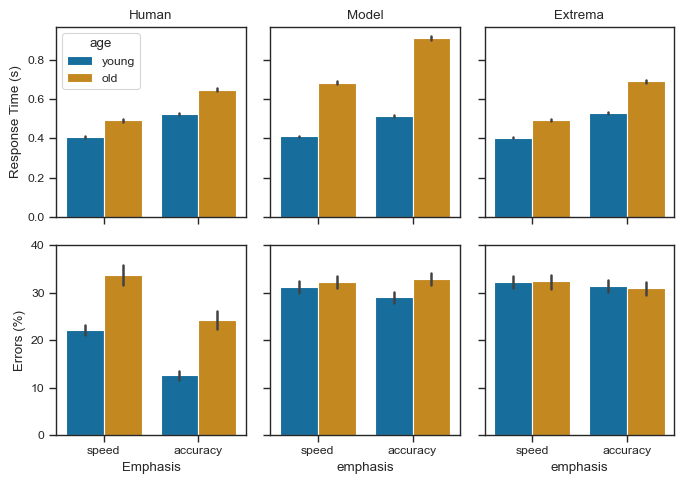

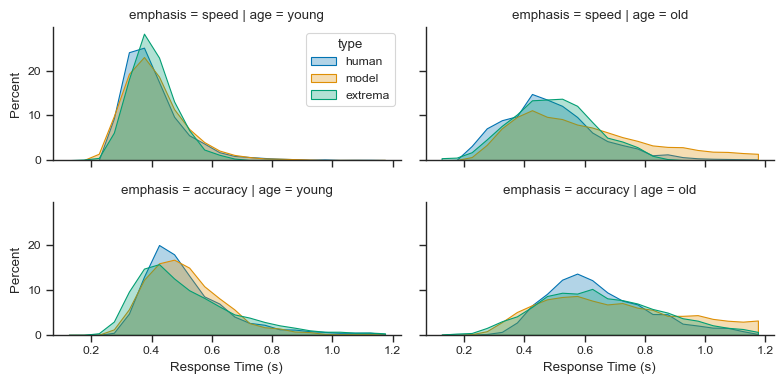

In [15]:
plot_speed_accuracy("forstmann_june25both", "forstmann2011", "forstmann_june26extrema")
plot_RTs("forstmann_june25both", "forstmann2011", "forstmann_june26extrema")

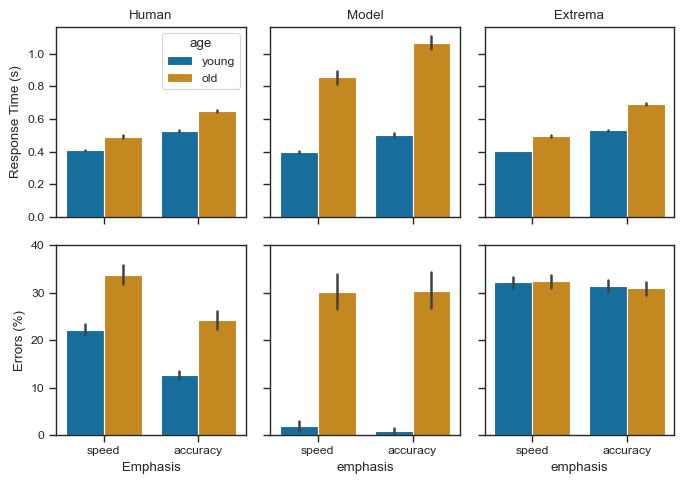

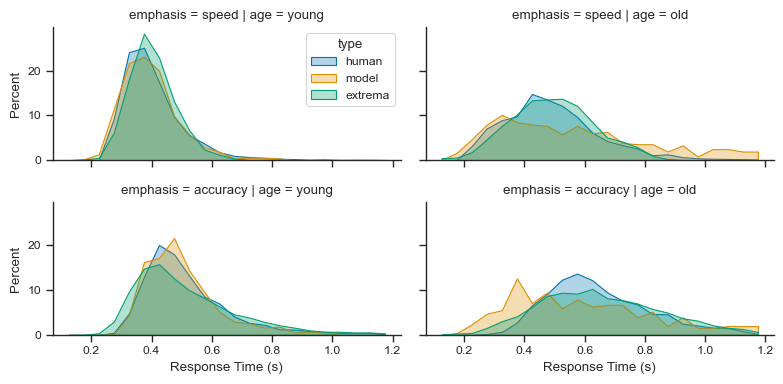

In [14]:
plot_speed_accuracy("forstmann_june26both", "forstmann2011", "forstmann_june26extrema")
plot_RTs("forstmann_june26both", "forstmann2011", "forstmann_june26extrema")

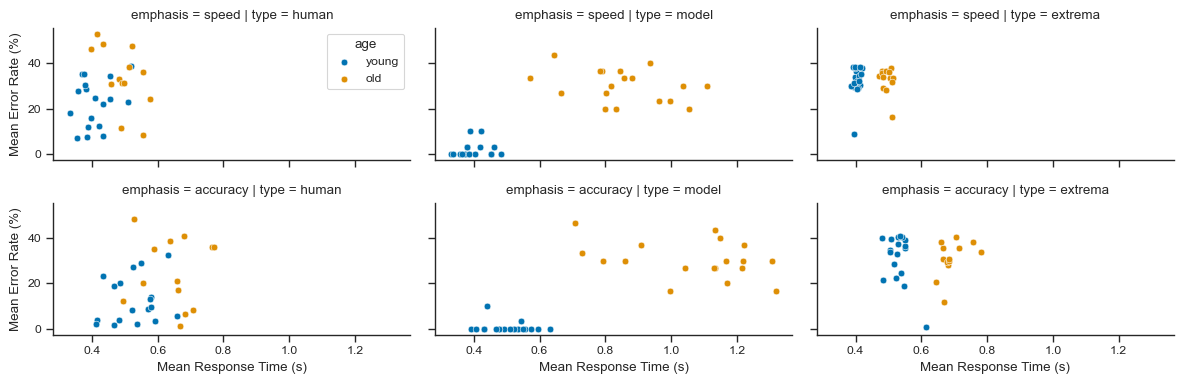

In [17]:
plot_SAT("forstmann_june26both", "forstmann2011", "forstmann_june26extrema")

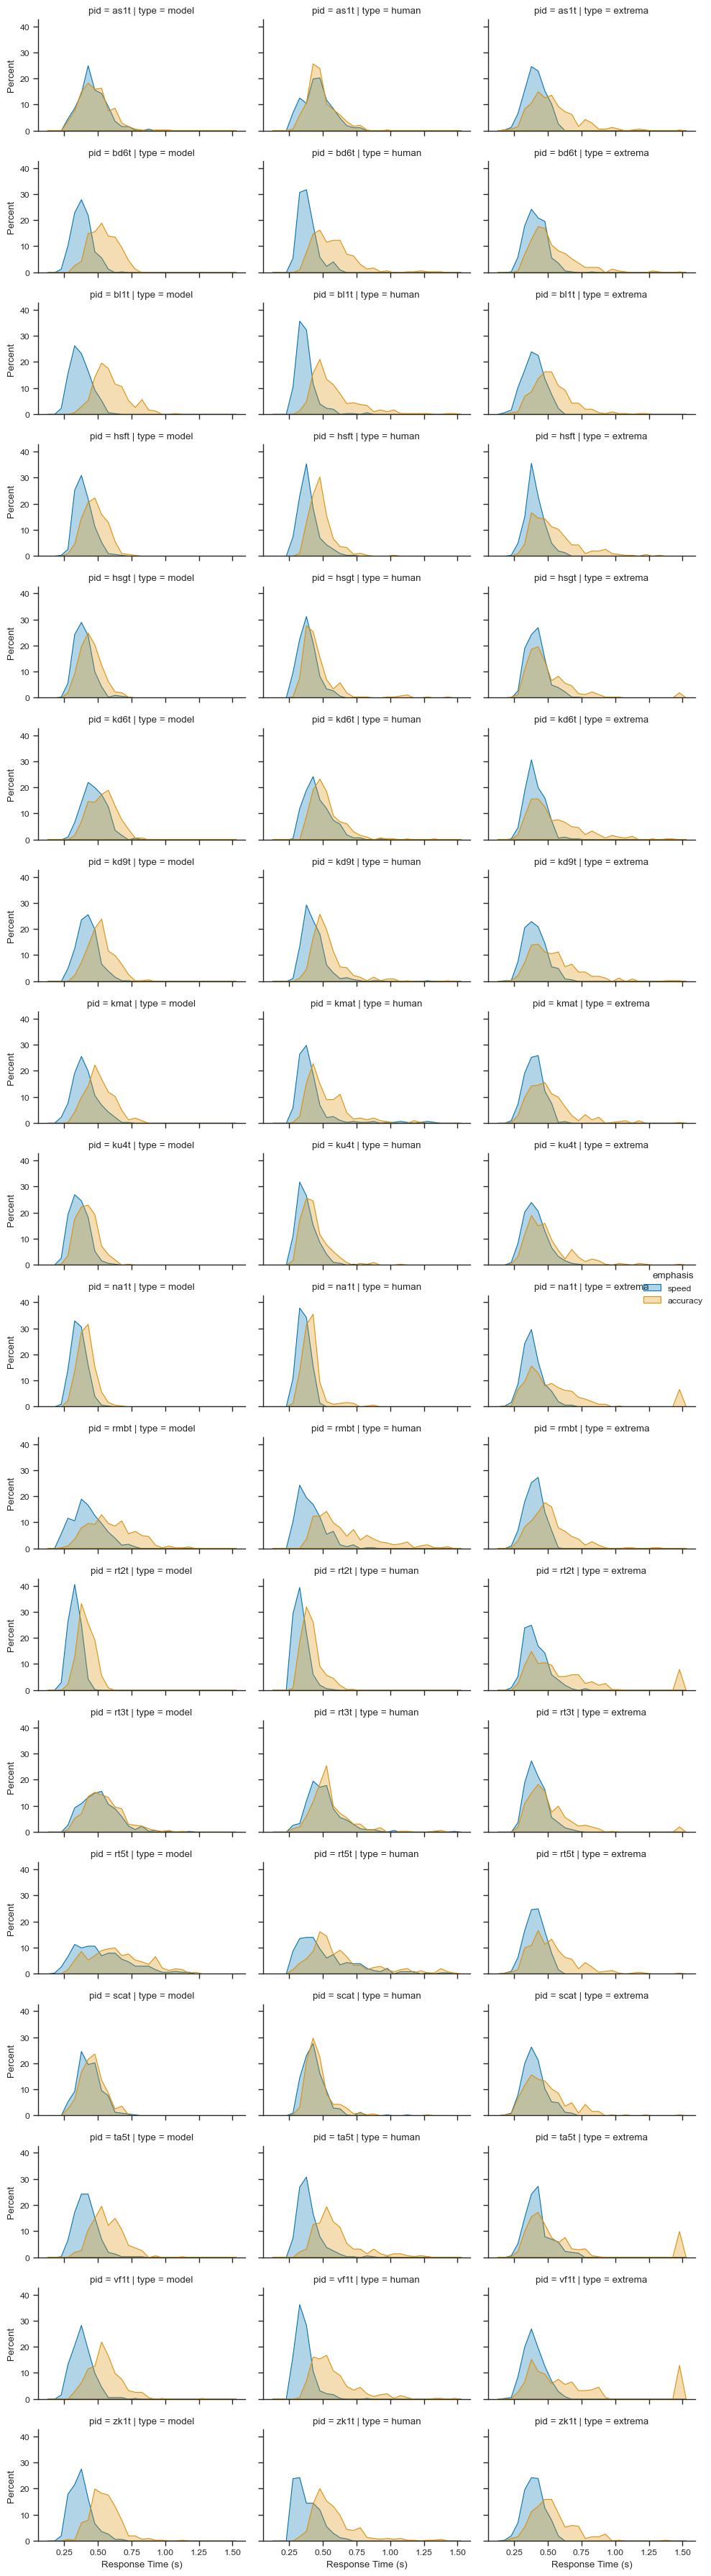

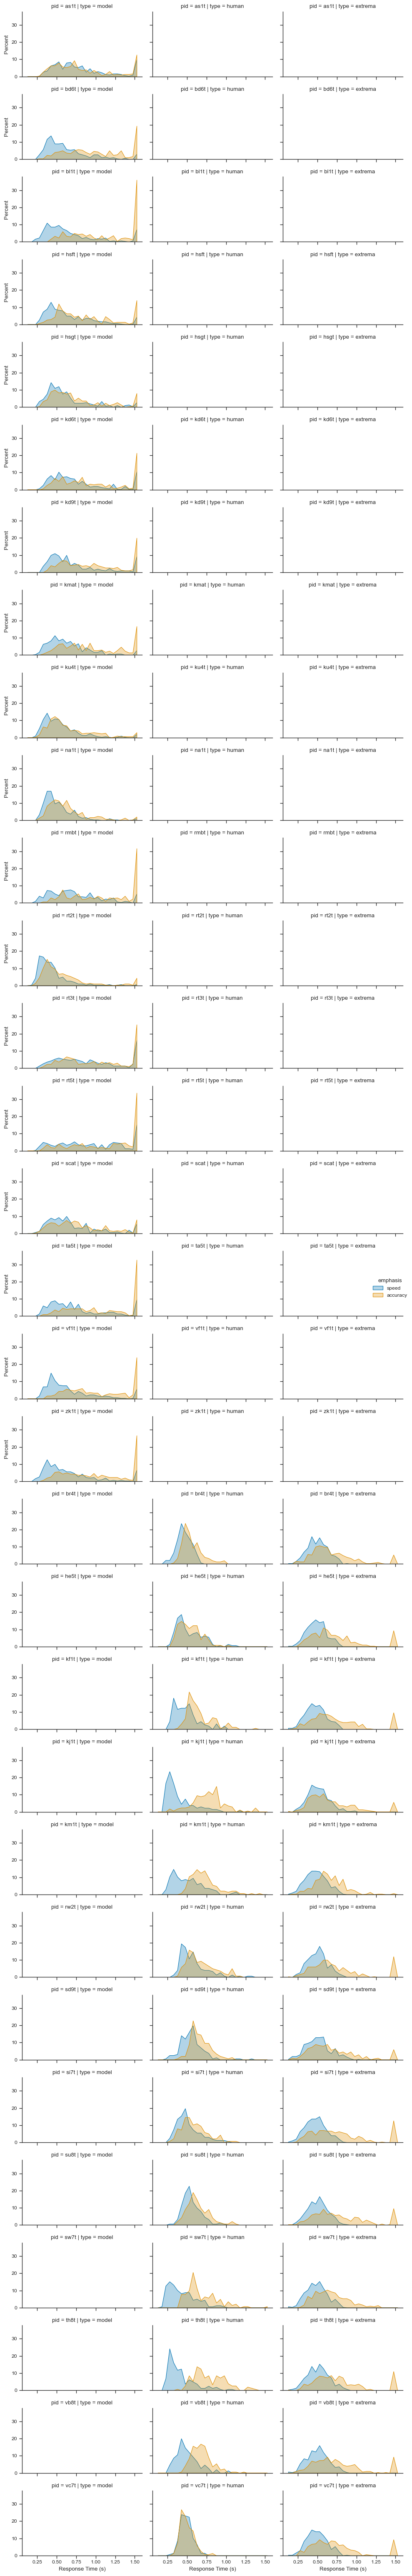

In [20]:
plot_RTs_individual("forstmann_june25both", "forstmann2011", "forstmann_june2425extrema", bins=np.arange(0.1, 1.6, 0.05))

### Extra

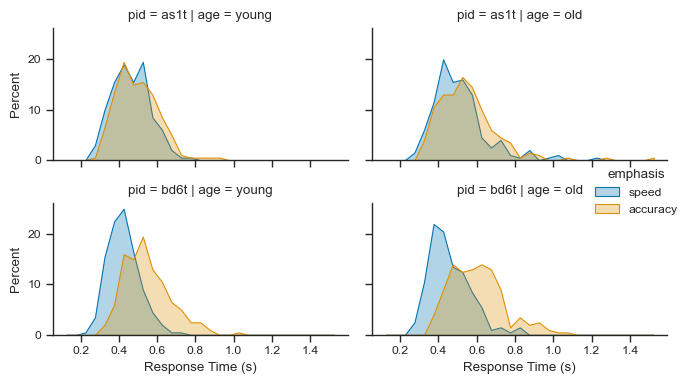

In [129]:
sim = pd.read_pickle("data/forstmann_june24old.pkl")
bins = np.arange(0.1, 1.6, 0.05)
order = ['speed', 'accuracy']
sim = sim.query("emphasis in @order")
fig = sns.FacetGrid(sim, col='age', hue='emphasis', row="pid", hue_order=order, palette=palette, height=2, aspect=1.5)
fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", bins=bins, common_norm=False, alpha=0.3)
fig.set_xlabels("Response Time (s)")
fig.add_legend()
plt.tight_layout()

In [130]:
sim = pd.read_pickle("data/forstmann_june24old.pkl")
for pid in sim['pid'].unique():
    for age in ['young', 'old']:
        for emphasis in ['speed', 'accuracy']:
            print(pid, age, emphasis, sim.query("pid==@pid & age==@age & emphasis==@emphasis")['error'].mean())

as1t young speed 33.5
as1t young accuracy 34.5
as1t old speed 26.0
as1t old accuracy 36.0
bd6t young speed 37.5
bd6t young accuracy 28.5
bd6t old speed 28.5
bd6t old accuracy 28.0


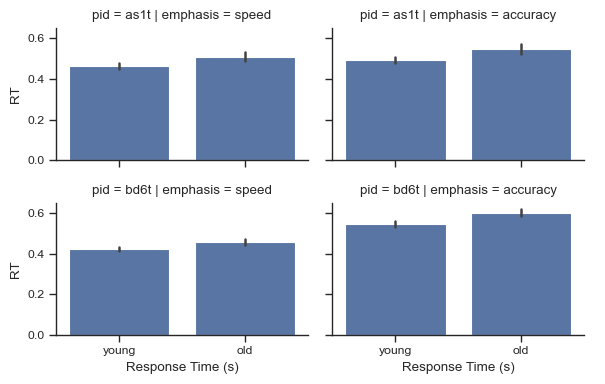

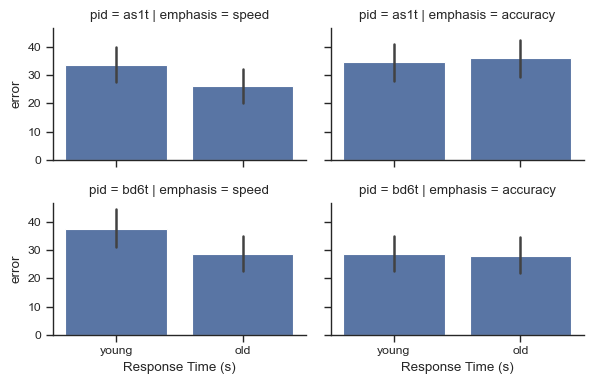

In [134]:
sim = pd.read_pickle("data/forstmann_june24old.pkl")
order = ['speed', 'accuracy']
sim = sim.query("emphasis in @order")
fig = sns.FacetGrid(sim, col='emphasis', row="pid", hue_order=order, palette=palette, height=2, aspect=1.5)
fig.map_dataframe(sns.barplot, x='age', y="RT")
fig.set_xlabels("Response Time (s)")
fig.add_legend()
plt.tight_layout()
fig = sns.FacetGrid(sim, col='emphasis', row="pid", hue_order=order, palette=palette, height=2, aspect=1.5)
fig.map_dataframe(sns.barplot, x='age', y="error")
fig.set_xlabels("Response Time (s)")
fig.add_legend()
plt.tight_layout()

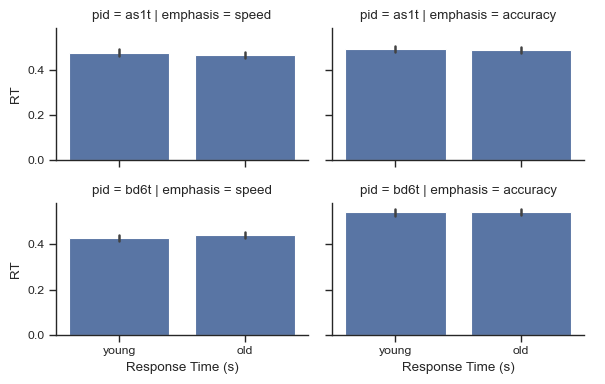

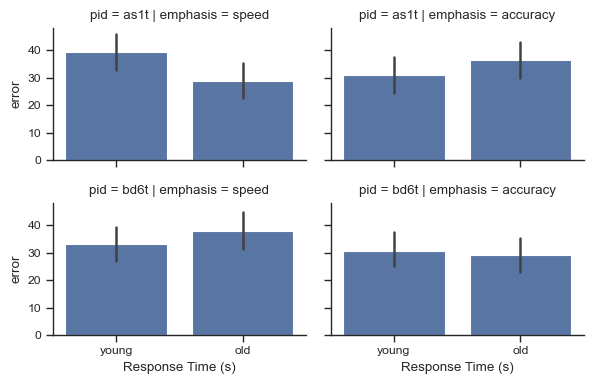

In [165]:
sim = pd.read_pickle("data/forstmann_june24degradespeed.pkl")
order = ['speed', 'accuracy']
sim = sim.query("emphasis in @order")
fig = sns.FacetGrid(sim, col='emphasis', row="pid", hue_order=order, palette=palette, height=2, aspect=1.5)
fig.map_dataframe(sns.barplot, x='age', y="RT")
fig.set_xlabels("Response Time (s)")
fig.add_legend()
plt.tight_layout()
fig = sns.FacetGrid(sim, col='emphasis', row="pid", hue_order=order, palette=palette, height=2, aspect=1.5)
fig.map_dataframe(sns.barplot, x='age', y="error")
fig.set_xlabels("Response Time (s)")
fig.add_legend()
plt.tight_layout()

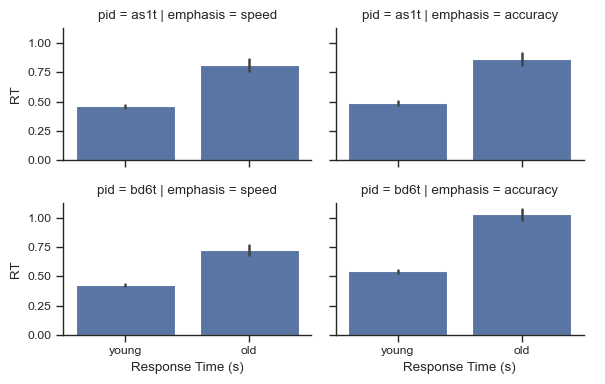

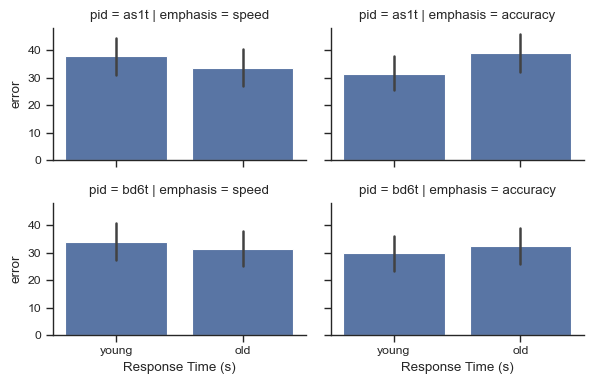

In [167]:
sim = pd.read_pickle("data/forstmann_june24degradeboth.pkl")
order = ['speed', 'accuracy']
sim = sim.query("emphasis in @order")
fig = sns.FacetGrid(sim, col='emphasis', row="pid", hue_order=order, palette=palette, height=2, aspect=1.5)
fig.map_dataframe(sns.barplot, x='age', y="RT")
fig.set_xlabels("Response Time (s)")
fig.add_legend()
plt.tight_layout()
fig = sns.FacetGrid(sim, col='emphasis', row="pid", hue_order=order, palette=palette, height=2, aspect=1.5)
fig.map_dataframe(sns.barplot, x='age', y="error")
fig.set_xlabels("Response Time (s)")
fig.add_legend()
plt.tight_layout()